# MNIST Database

The `MNIST` database (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used for training various image processing systems. Widely used for training and testing in the field of machine learning.

- handrawn digits (Note: `EMNIST` includes upper and lower case digits)
- 28x28 pixel
- grayscale
- ~70,000 labelled images.

## Loading this via `torchvision`

A pytorch extension that consists of popular datasets, yet critically baking into them the separation of training and testing datasets to enforce a bit more consistency across research, as everyone uses the same split - allows for comparable benchmarking of models.

`torchvision` allows you to "transform" your data as you load it in, which is typically required as you interface your dataset with your NN. We will explicitly avoid the use of this utility to describe nessecary transformations explicitly later. I'm still learning after all.

In [1]:
from torchvision import datasets

train_dataset = datasets.MNIST('./data', train=True, download=True)
test_dataset = datasets.MNIST('./data', train=False)

These are in what is known as a PIL format - tbh I'm not too sure about this format 🤷‍♂️ - but you can draw them and see the raw internal structure in the following way;

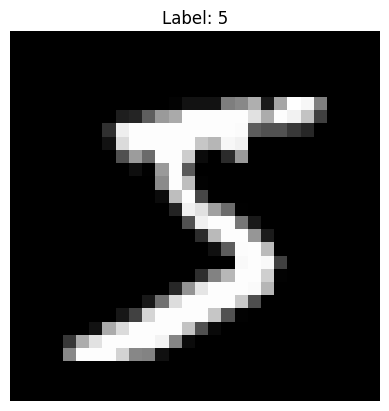

In [2]:
import matplotlib.pyplot as plt

image, label = train_dataset[0]

plt.imshow(image, cmap="grey") # To note; even though images are 3D in practice in shape, because these images only operate on one colour channel; these are structurally 2D formats.
plt.title(f'Label: {label}')
plt.axis('off')
plt.show()

But don't be fooled, the underlying structure is simple - especially considering the grayscale nature of the image. Each incident cell of the 28x28 matrix has a value between 0 and 255.

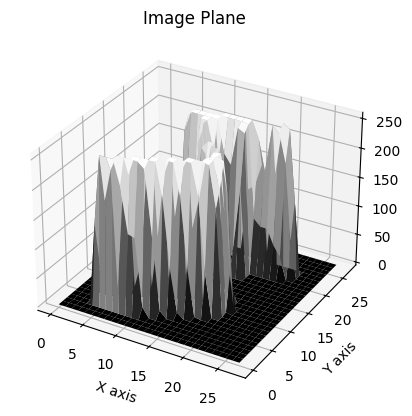

In [3]:
import numpy as np

image_array = np.array(image) # from PIL image object back to an array

x = np.arange(image_array.shape[1])
y = np.flip(np.arange(image_array.shape[0]))
x, y = np.meshgrid(x, y)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, image_array, cmap='gray')

ax.set_title('Image Plane')
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')

plt.show()

# Defining NN Inputs and thinking about Normalization

We can easily feed each of these cells input into a respective input neuron - but we should think about the mechanics of each neuron in our neural network.

## Common activation functions
Are typically exhibit most behaviour between ranges -1 to 1, increasing towards 0

## Normalization
Commonly min-max is used to introduce this concept, seen to commonly produce ranges of results between [0,1] - but stepping beyond this, *z-score* normalization is what you see in industry the most. We transform the data to have a mean of 0 and a standard deviation of 1.

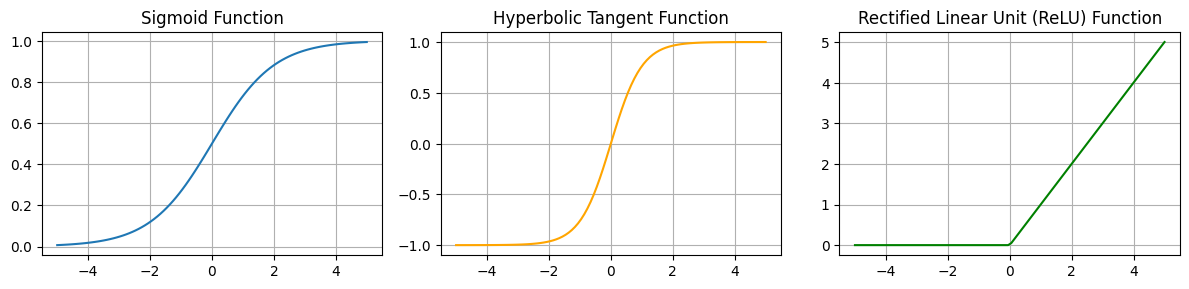

In [4]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)


x = np.linspace(-5, 5, 100) # generates a range of values from -5 to 5 for x

y_sigmoid = sigmoid(x)
y_tanh = tanh(x)
y_relu = relu(x)


plt.figure(figsize=(12, 8))

plt.subplot(3, 3, 1)
plt.plot(x, y_sigmoid, label='Sigmoid')
plt.title('Sigmoid Function')
plt.grid(True)

plt.subplot(3, 3, 2)
plt.plot(x, y_tanh, color='orange', label='tanh')
plt.title('Hyperbolic Tangent Function')
plt.grid(True)

plt.subplot(3, 3, 3)
plt.plot(x, y_relu, color='green', label='ReLU')
plt.title('Rectified Linear Unit (ReLU) Function')
plt.grid(True)

plt.tight_layout()
plt.show()

In [5]:
import torch
from torchvision import transforms

sums = 0
sums_sq = 0
n_samples = 0

for data, _ in train_dataset:
    data_tensor = transforms.ToTensor()(data) # NOTE; as above, this tensor has a [1, 28, 28] dimension space - effectively 2D
    sums += torch.sum(data_tensor)
    sums_sq += torch.sum(data_tensor ** 2)
    n_samples += data_tensor.numel()

mean = sums / n_samples
std = ((sums_sq / n_samples) - (mean ** 2)) ** 0.5

print(f'Mean: {mean:.4f}, Std: {std:.4f}')

Mean: 0.1307, Std: 0.3081


## Transforming the test/train datasets

In [6]:
normalize_transform = transforms.Normalize((mean,), (std,))

def normalize_dataset(dataset):
    normalized_data = []
    for img, label in dataset:
        img_tensor = transforms.ToTensor()(img)
        normalized_img = normalize_transform(img_tensor)
        normalized_data.append((normalized_img, label))
    return normalized_data

normalized_train_dataset = normalize_dataset(train_dataset)
normalized_test_dataset = normalize_dataset(test_dataset)

### Mini-batch SGD will be our training approach
The `DataLoader` class in `pytorch` conveniently handles the stochastic, mini-batch sourcing of our training data, wrapping in it the shuffling then batch sourcing for training our NN. Note;

The choice of batch size is a trade-off:

- Larger batches provide a more accurate estimate of the gradient but require more memory and can lead to a less exploratory update path, potentially getting stuck in shallow local minima.
- Smaller batches offer more update opportunities and better generalization at the cost of increased noise in the updates and potentially longer training times.

In [7]:
import torch

batch_size = 2^6

train_loader = torch.utils.data.DataLoader(normalized_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(normalized_test_dataset, batch_size=batch_size, shuffle=False)

## Re-introducing you to typical NN's
Interestingly, `pytorch` which is the SOTA ML framework today, is actually built upon on the early lua implementation of [the torch library](https://en.wikipedia.org/wiki/Torch_(machine_learning)). Came in during 2017 and has unequivocally been the top tool for ML research since.

Note; `pytorch` comes with a comprehensive `nn` package that handles common activation functions, architecture implementation for various SOTA NN's - this library is also hella extensible.

### Our architecture
Ofcourse we want to stay simple here as we progress to more complex S-NN's, so we will define a;
- 28*28 ($\approx$ 2^10) input layer (corresponding to each pixel cell) that yields 2^8 outputs.
- 2^8 hidden layer that yields 10 outputs.
- final output of size 10 is the result of this NN.

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 2^8)
        self.fc2 = nn.Linear(2^8, 10)

    def forward(self, x):
        x = x.view(-1, 28*28) # flattens each tensor to a 1D array ready for network feeding
        # NOTE: the -1 infers batch_size by the passed in x, -1 to keep dyanmic.
        x = F.relu(self.fc1(x))
        x = self.fc2(x) # note lack of activation function as output layer just "summarizes" results. 
        return x

model = SimpleNN()

# Loss Function and Optimization Method Notes
I'm familiar with two main loss functions, one for regression and one for classification. Both operate on;

- $N$ is the number of observations.
- $y_i$ is the actual label for the $i^{th}$ observation.
- $\hat{y}_i$ is the predicted value for the $i^{th}$ observation.

They look arbitrary, but they are specifically desgined to be "smooth" functions that allows differentiability to allow us to perform **gradient descent**.

### Regression Loss
The classic mean-square-error equation.
$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2 \text{ and note; }
\frac{\partial \text{MSE}}{\partial \hat{y}_i} = \frac{2}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)
$$

### Classification Loss
I've only really known of the Cross-Entropy Loss ($CEL$) function - enter the binary variant;

$$
\text{CEL}_\text{Binary} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(\hat{y}_i) + (1 - y_i) \log(1 - \hat{y}_i) \right]
$$
With it's partial derivative;
$$
\frac{\partial \text{CEL}_\text{Binary}}{\partial \hat{y}_i} = -\frac{1}{N} \sum_{i=1}^{N} \left[ \frac{y_i}{\hat{y}_i} - \frac{1 - y_i}{1 - \hat{y}_i} \right]
$$

- Note: $y_i$ is now either 0 or 1, and,
- $\hat{y}_i$ is a probability in [0,1]. 

Which leads us to generalise for $C$ different classes.
$$
\text{CEL}_\text{Multi} = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

With it's partial derivative;
$$
\frac{\partial \text{CEL}_\text{Multi}}{\partial \hat{y}_{i,c}} = -\frac{1}{N} \sum_{i=1}^{N} \frac{y_{i,c}}{\hat{y}_{i,c}}
$$

- $y_{i,c}$ is a binary indicator of whether class $c$ is the correct classification for observation $i$.
- $\hat{y}_{i,c}$ is the predicted probability of observation $i$ being of class $c$.

## Optimization
Gradient descent is applied...

# Criterion being the Cross Entropy Loss
Mini-batched backward propogating gradient descent.

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01) # LR; learning rate (hyper parameter)

# Training the model
Each step, or `epoch` has a forward pass to evaluate the step loss which gets propogated back up the NN to perform a gradient descent via chain rule.

In [10]:
epochs = 10

loss_history = []
accuracy_history = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.
    correct_predictions = 0
    total_predictions = 0

    
    for images, labels in train_loader:
        optimizer.zero_grad()  # Zero the parameter gradients
        
        outputs = model(images)
        loss = criterion(outputs, labels) # forward pass
        
        loss.backward() # propogate backwards the loss, set models gradients at each parameter
        optimizer.step() # use respective model weight associated gradients to perform a descent step
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = (correct_predictions / total_predictions) * 100
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

Epoch [1/10], Loss: 0.3646, Accuracy: 89.10%
Epoch [2/10], Loss: 0.2694, Accuracy: 91.99%
Epoch [3/10], Loss: 0.2481, Accuracy: 92.79%
Epoch [4/10], Loss: 0.2360, Accuracy: 93.06%
Epoch [5/10], Loss: 0.2285, Accuracy: 93.29%
Epoch [6/10], Loss: 0.2209, Accuracy: 93.54%
Epoch [7/10], Loss: 0.2171, Accuracy: 93.64%
Epoch [8/10], Loss: 0.2136, Accuracy: 93.68%
Epoch [9/10], Loss: 0.2121, Accuracy: 93.78%
Epoch [10/10], Loss: 0.2094, Accuracy: 93.85%


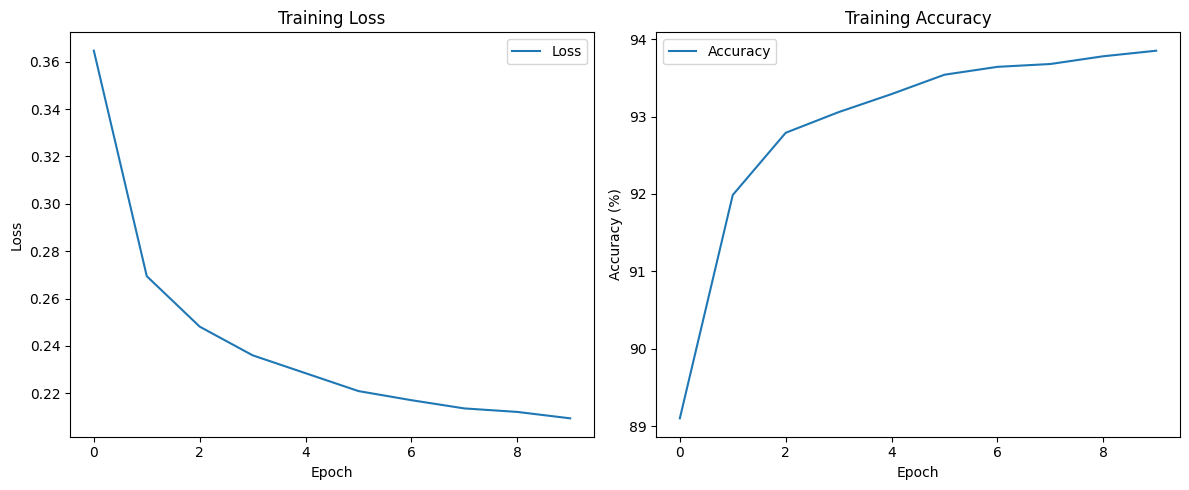

In [11]:
# Plotting the loss and accuracy curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
There are various metrics we can gather, but the cleanest is just the raw accuracy. But when comparing models, we will need to get a bit better here to prove statstically significant differences.

In [12]:
model.eval()  # Set the model to evaluation mode

correct = 0
total = 0
for images, labels in test_loader:
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total}%')

Accuracy of the network on the 10000 test images: 93.27%
